In [72]:
import os
os.chdir("../")
print(os.getcwd() )
import glob
import tqdm
import json

mutant_meta_list = json.load(open("datasets/MutantBench/mutantbench/dataset.json", "r"))
mutant_meta = {}
for m in mutant_meta_list:
    mutant_meta[m["@id"]] = m


# mb:mutant#
mutant_folder = "datasets/MutantBench/mutantbench/chatgpt"
output_file = "datasets/MutantBench/mutantbench/chatgpt_zeroshot_predictions.csv"

res_false = [ ]
false_folder = os.path.join(mutant_folder, "false")
for f in tqdm.tqdm( glob.glob(f"{false_folder}/**/answer.md", recursive=True) ):
   
    question_file = os.path.dirname(f)+"/question.md"
    answer = open(f).read().strip()
    question = open(question_file).read().strip()
    l = -1
    mid = "mb:mutant#"+os.path.basename(os.path.dirname(f))
    #print( mutant_meta[mid]["https://b2share.eudat.eu/records/153db16ce2f6401298a9aea8b0ab9781/operator"])
    operator = mutant_meta[mid]["https://b2share.eudat.eu/records/153db16ce2f6401298a9aea8b0ab9781/operator"][0]["@id"]
    
    if answer.lower().startswith("no"):
        l  = 0
    elif answer.lower().startswith("yes"):
        l  = 1
    else:
        print("unknown")
        continue
    res_false.append( {"answer":answer, "question":question,  "label":0, "predict":l, "isCorrect":l==0, "operator":operator} )

true_folder = os.path.join(mutant_folder, "true")
res_true = []
for f in tqdm.tqdm( glob.glob( f"{true_folder}/**/answer.md", recursive=True) ):
    question_file = os.path.dirname(f)+"/question.md"
    answer = open(f).read().strip()
    question = open(question_file).read().strip()
    l = -1
    mid = "mb:mutant#"+os.path.basename(os.path.dirname(f))
    operator = mutant_meta[mid]["https://b2share.eudat.eu/records/153db16ce2f6401298a9aea8b0ab9781/operator"][0]["@id"]
    if answer.lower().startswith("no"):
        l  = 0
    elif answer.lower().startswith("yes"):
        l  = 1
    else:
        print("unknown")
        continue
    res_true.append( {"answer":answer, "question":question,  "label":1, "predict":l, "isCorrect":l==1, "operator":operator} )

res = res_false+ res_true
print(res)

100%|██████████| 100/100 [00:00<00:00, 13048.08it/s]

[{'answer': 'no', 'question': "Please analyze the two following provided code files in C or Java. Identify if they are semantically equal. 'Semantically equal' means two codes have the same meaning, that they have the same output given the same input.\n\n\nPlease identify if the two following codes are semantically equal. Please only answer `yes` or `no`. `yes` means they are semantically equal. `no` means they are not. \nInput :\n    ```Code \n// This is a mutant program.\n// Author : ysma\n\npublic class Bisect\n{\n\n    double mEpsilon;\n\n    double mNumber;\n\n    double mResult;\n\n    public Bisect()\n    {\n    }\n\n    public  void setEpsilon( double epsilon )\n    {\n        this.mEpsilon = epsilon;\n    }\n\n    public  double sqrt( double N )\n    {\n        double x = N;\n        double M = N;\n        double m = 1;\n        double r = x;\n        double diff = x * x - N;\n        while (Math.abs(diff) > mEpsilon) {\n            if (diff < 0) {\n                m = x;\n   

In [80]:
import pandas as pd
def draw_graph(res, name="datasets/figures/mutant_prediction_zero_positive.pdf"):
    if type(res) == list:
        print("convert")
        df = pd.DataFrame.from_records(res)
    else:
        df = res
    operator_num = []
    correct_num_each = []
    names = []
    for n, d in df.groupby(['operator'], group_keys=True):
        # print(n)
        # print(len(d))
        names.append( n.split("#")[-1] )
        operator_num.append( len(d) - d["isCorrect"].sum() )
        correct_num_each.append(d["isCorrect"].sum())
        # print(d["isCorrect"].sum())
    # create DataFrame
    print(correct_num_each)
    res_df = pd.DataFrame({'Correct': correct_num_each,
                    'Wrong':operator_num},
                    index=names)
    
    
    # create stacked bar chart for monthly temperatures
    res_df.plot(kind='bar', stacked=True,  alpha=0.7)

    import matplotlib.pyplot as plt
    # labels for x & y axis
    plt.xticks(rotation=80, fontsize=10)
    plt.yticks(fontsize=16)
    plt.xlabel('Operator', fontsize=16)
    plt.ylabel('Prediction Number', fontsize=16)
    plt.tight_layout()
    plt.savefig(name)

In [74]:

df = pd.DataFrame.from_records(res)
df.to_csv(output_file)
df["isCorrect"].sum()/len(df)
print(len(df))
print(df["isCorrect"].sum()/len(df))



200
0.665


convert
[12, 8, 0, 8, 12]
TP 40 FN 60 
 TN 93 FP 7
100 100 ACC 0.665 F1 0.54421768707483 Mcc 0.3891520257224738 Recall 0.4 Precision 0.851063829787234


/tmp/ipykernel_410083/2485926003.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for n, d in df.groupby(['operator'], group_keys=True):


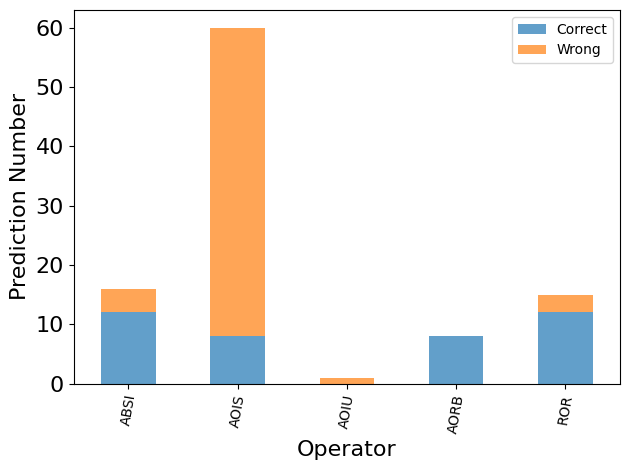

In [82]:
#draw_graph(df)
draw_graph(res_true, name="datasets/figures/mutant_prediction_zero_positive.pdf")
#draw_graph(res_false)
#[10, 14, 0, 8, 14]
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, f1_score, matthews_corrcoef, precision_score
y = df["label"]
y_pre = df["predict"]
acc = accuracy_score(y,  y_pre)
f1 = f1_score(y,  y_pre)
mcc = matthews_corrcoef(y,  y_pre)
recall = recall_score(y,  y_pre)
p = precision_score(y, y_pre)
tn, fp, fn, tp = confusion_matrix(y,  y_pre).ravel()
print(f"TP {tp} FN {fn} \n TN {tn} FP {fp}")
print(f"{sum(y)} {len(y)-sum(y)} ACC {acc} F1 {f1} Mcc {mcc} Recall {recall} Precision {p}")

In [83]:
import os
import glob
import tqdm

mutant_folder = "datasets/MutantBench/mutantbench/chatgpt_fewshot"
output_file = "datasets/MutantBench/mutantbench/chatgpt_fewshot_predictions.csv"


res = [ ]
false_folder = os.path.join(mutant_folder, "false")
res_false_one = []
for f in tqdm.tqdm( glob.glob(f"{false_folder}/**/answer.md", recursive=True) ):
    question_file = os.path.dirname(f)+"/question.md"
    answer = open(f).read().strip()
    question = open(question_file).read().strip()
    l = -1
    mid = "mb:mutant#"+os.path.basename(os.path.dirname(f))
    operator = mutant_meta[mid]["https://b2share.eudat.eu/records/153db16ce2f6401298a9aea8b0ab9781/operator"][0]["@id"]
    if answer.lower().startswith("no"):
        l  = 0
    elif answer.lower().startswith("yes"):
        l  = 1
    else:
        print("unknown")
        continue
    res_false_one.append( {"answer":answer, "question":question,  "label":0, "predict":l, "isCorrect":l==0, "operator":operator} )

true_folder = os.path.join(mutant_folder, "true")
res_true_one =[]
for f in tqdm.tqdm( glob.glob( f"{true_folder}/**/answer.md", recursive=True) ):
    question_file = os.path.dirname(f)+"/question.md"
    answer = open(f).read().strip()
    question = open(question_file).read().strip()
    l = -1
    mid = "mb:mutant#"+os.path.basename(os.path.dirname(f))
    operator = mutant_meta[mid]["https://b2share.eudat.eu/records/153db16ce2f6401298a9aea8b0ab9781/operator"][0]["@id"]
    if answer.lower().startswith("no"):
        l  = 0
    elif answer.lower().startswith("yes"):
        l  = 1
    else:
        print("unknown")
        continue
    res_true_one.append( {"answer":answer, "question":question,  "label":1, "predict":l, "isCorrect":l==1, "operator":operator} )
res = res_false_one + res_true_one
import pandas as pd
df_oneshot = pd.DataFrame.from_records(res)
df_oneshot.to_csv(output_file)
df_oneshot["isCorrect"].sum()/len(df_oneshot)
print(len(df_oneshot))
print(df_oneshot["isCorrect"].sum()/len(df_oneshot))

100%|██████████| 100/100 [00:00<00:00, 10984.17it/s]

200
0.63


convert
[10, 14, 0, 8, 14]
TP 46 FN 54 
 TN 80 FP 20
100 100 ACC 0.63 F1 0.5542168674698795 Mcc 0.2764706165384237 Recall 0.46 Precision 0.696969696969697


/tmp/ipykernel_410083/2485926003.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for n, d in df.groupby(['operator'], group_keys=True):


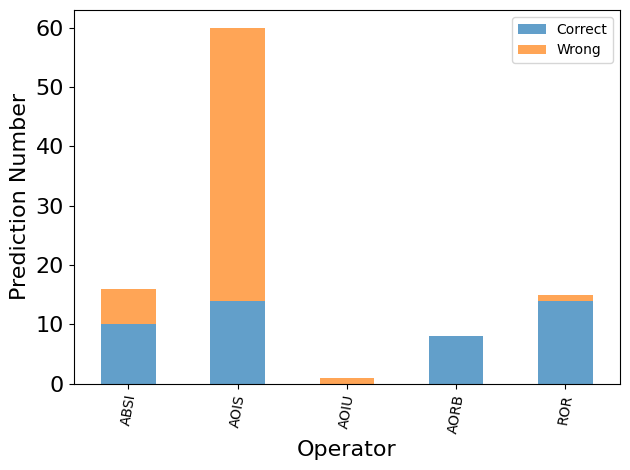

In [84]:
#draw_graph(df)
draw_graph(res_true_one, name="datasets/figures/mutant_prediction_one_positive.pdf")
#draw_graph(res_false)
#[10, 14, 0, 8, 14]
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, f1_score, matthews_corrcoef, precision_score
y = df_oneshot["label"]
y_pre = df_oneshot["predict"]
acc = accuracy_score(y,  y_pre)
f1 = f1_score(y,  y_pre)
mcc = matthews_corrcoef(y,  y_pre)
recall = recall_score(y,  y_pre)
p = precision_score(y, y_pre)
tn, fp, fn, tp = confusion_matrix(y,  y_pre).ravel()
print(f"TP {tp} FN {fn} \n TN {tn} FP {fp}")
print(f"{sum(y)} {len(y)-sum(y)} ACC {acc} F1 {f1} Mcc {mcc} Recall {recall} Precision {p}")

/tmp/ipykernel_410083/2428771265.py:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for n, d in df_oneshot.groupby(['operator'], group_keys=True):


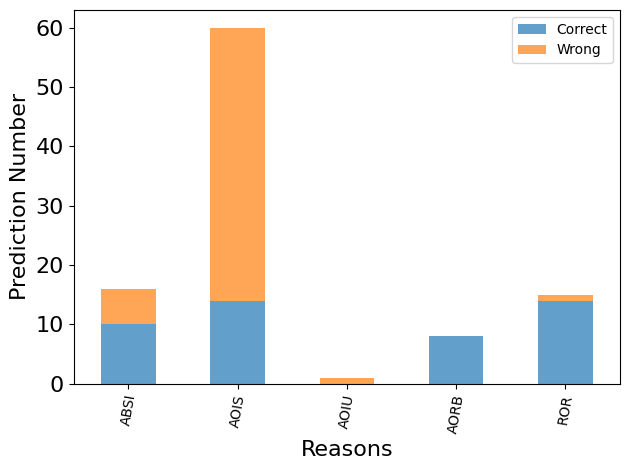

In [40]:
draw_graph(df)

In [1]:
import os
os.chdir("all_datasets/mutant_test/")
print(os.getcwd() )

/ChatGPT_analysis_latest/all_datasets/mutant_test


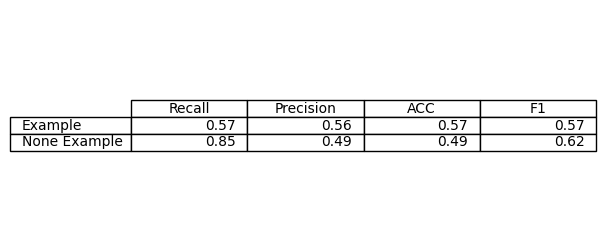

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 
data = {
    "Recall": [0.57, 0.85],  # 
    "Precision": [0.56, 0.49],  # 
    "ACC": [0.57, 0.49],    # F1
    "F1": [0.57, 0.62]
}

# DataFrame
df = pd.DataFrame(data, index=["Example", "None Example"])

# 
fig, ax = plt.subplots(figsize=(6, 3))  # 
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')

plt.savefig('performance_starchat.png')
plt.show()


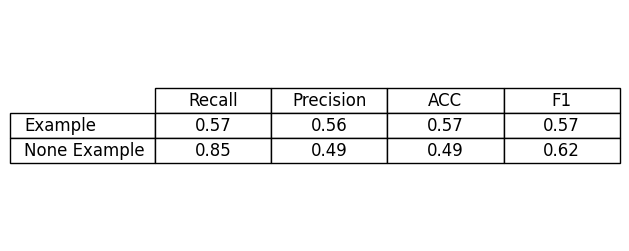

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
confusion_matrix = pd.DataFrame(
    data,
    index=['Example', 'None Example']
)
    
# 
fig, ax = plt.subplots(figsize=(6, 3))  # 
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=confusion_matrix.values, colLabels=confusion_matrix.columns,
                 rowLabels=confusion_matrix.index, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)  # 
table.scale(1, 1.5)  # 

# 
plt.savefig('starchat_performance.png', bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()


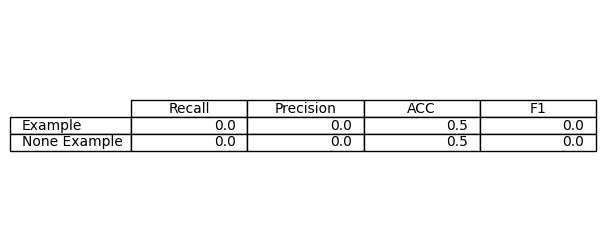

In [4]:
from matplotlib import pyplot as plt
import pandas as pd
confusion_matrix = pd.DataFrame(
    data,
    index=['Example', 'None Example']
)
    
# 
fig, ax = plt.subplots(figsize=(6, 3))  # 
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=confusion_matrix.values, colLabels=confusion_matrix.columns,
                 rowLabels=confusion_matrix.index, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)  # 
table.scale(1, 1.5)  # 

# 
plt.savefig('codellama_performance.png', bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()
